# Testing the models

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score,roc_auc_score,classification_report,jaccard_score, hamming_loss
import json
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re 
import string
import matplotlib.pyplot as plt
import joblib

In [ ]:
#load models

MLP =  tf.keras.models.load_model('./models/modelMLP_fold_5.keras')

CNN =  tf.keras.models.load_model('./models/modelCNN_fold_5.keras')

SVM = joblib.load("./models/svm.pkl")

In [3]:
# load dataset
key = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
test_data = pd.read_csv("./data/test.csv/test.csv")
label_data = pd.read_csv("./data/test_labels.csv/test_labels.csv")
label_data = label_data[:].replace(-1, 1)
label_data

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1,1,1,1,1,1
1,0000247867823ef7,1,1,1,1,1,1
2,00013b17ad220c46,1,1,1,1,1,1
3,00017563c3f7919a,1,1,1,1,1,1
4,00017695ad8997eb,1,1,1,1,1,1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,1,1,1,1,1,1
153160,fffd7a9a6eb32c16,1,1,1,1,1,1
153161,fffda9e8d6fafa9e,1,1,1,1,1,1
153162,fffe8f1340a79fc2,1,1,1,1,1,1


In [4]:
# Load the tokenizer JSON
with open("tokenizer.json", "r") as f:
    tokenizer_json = f.read()
    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_json)

# Load the tf_IDF
vectorizer = joblib.load("./models/vek.pkl")

In [5]:

lemmatizer = WordNetLemmatizer()

nlp = spacy.load('en_core_web_sm')

def remove_upper(text):
    return text.lower()

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_username(text):
    words = text.split()
    username = re.compile(r'^[a-zA-Z0-9]+[?=.*\d]$')

    def remove_username_from_word(word):
        if re.match(username, word):
            return ""
        else:
            return word

    words = text.split()
    tokens = [remove_username_from_word(word) for word in words]
    text = " ".join(tokens)

    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def lemmatize_text(text):
    words = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    lem_text = " ".join(lemmas)
    return lem_text

def clean_text(text):

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]

    # Rimozione di numeri (puoi personalizzare questa parte)
    tokens = [token for token in tokens if not token.isdigit()]

    # Unisci i token in una stringa
    clean_text = ' '.join(tokens)

    return clean_text

def pre_processing_data(df): 
    df['comment_text']=df['comment_text'].apply(lambda x : remove_upper(x))
    df['comment_text']=df['comment_text'].apply(lambda x : remove_URL(x))
    df['comment_text']=df['comment_text'].apply(lambda x : remove_username(x))
    df['comment_text']=df['comment_text'].apply(lambda x : remove_html(x))
    df['comment_text']=df['comment_text'].apply(lambda x: remove_emoji(x))
    df['comment_text']=df['comment_text'].apply(lambda x: lemmatize_text(x))
    df['comment_text']=df['comment_text'].apply(lambda x : remove_punct(x))
    return df

data_cleaned = pre_processing_data(test_data)
data_cleaned.to_csv("cleaned_data_train.csv",index=False)

In [ ]:
sentences = data_cleaned["comment_text"].fillna("DUMMY_VALUE").values
svm_data = vectorizer.fit_transform(data_cleaned["comment_text"].fillna(''))

sequences = tokenizer.texts_to_sequences(sentences)

data = tf.keras.utils.pad_sequences(sequences, 100)

y_pred_mlp = MLP.predict(data)
y_pred_cnn = CNN.predict(data)
y_pred_svm = SVM.predict(svm_data)

pred_mlp = np.array(y_pred_mlp)
pred_mlp = np.where(pred_mlp > 0.5, 1, 0).astype(int)

pred_cnn = np.array(y_pred_cnn)
pred_cnn = np.where(pred_cnn > 0.5, 1, 0).astype(int)

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
4787/4787 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step


In [69]:
from sklearn.metrics import average_precision_score, precision_recall_curve
import seaborn as sns

def plot_accuracies(accuracies_list, categories, model_names):

    num_models = len(model_names)
    num_categories = len(categories)
    bar_width = 0.15  # Larghezza delle barre
    bar_positions = np.arange(num_categories)

    # Crea il grafico
    plt.figure(figsize=(12, 6))  # Regola le dimensioni del grafico

    for i, model_name in enumerate(model_names):
        accuracies = accuracies_list[i]  # Ottieni le accuratezze per il modello corrente
        offset = i * bar_width
        plt.bar(bar_positions + offset, accuracies, bar_width, label=model_name)

    # Personalizza il grafico
    plt.xlabel("Categorie di Classificazione")
    plt.ylabel("Accuratezza")
    plt.title("Accuratezza dei Modelli per Categoria")
    plt.xticks(bar_positions + (num_models - 1) * bar_width / 2, categories, rotation=45, ha="right")  # Ruota le etichette sull'asse x
    plt.legend()
    plt.tight_layout()  # Aggiusta il layout per evitare sovrapposizioni
    plt.show()


def plot_classification_report(y_true, y_pred, classes,score):

    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

    # Estrai le metriche dal rapporto
    precision = [report[cls]['precision'] for cls in classes]
    recall = [report[cls]['recall'] for cls in classes]
    f1_score = [report[cls]['f1-score'] for cls in classes]

    # Prepara i dati per il grafico
    x = np.arange(len(classes))
    width = 0.2

    # Crea il grafico a barre
    fig, ax = plt.subplots(figsize=(8, 6))
    rects1 = ax.bar(x - width, precision, width, label='Precision')
    rects2 = ax.bar(x, recall, width, label='Recall')
    rects3 = ax.bar(x + width, f1_score, width, label='F1-score')

    # Aggiungi etichette e titoli
    ax.set_ylabel('Score')
    ax.set_title(score)
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    # Aggiungi valori sopra le barre
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            percentage = height * 100 
            ax.annotate('{:.1f}%'.format(percentage),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()

def create_boxplot_models(data_models, titolo="Confronto Accuracy Modelli", etichetta_asse_y="Accuracy"):

    data = pd.DataFrame(data_models)

    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data)

    plt.ylabel(etichetta_asse_y)
    plt.title(titolo)

    plt.show()


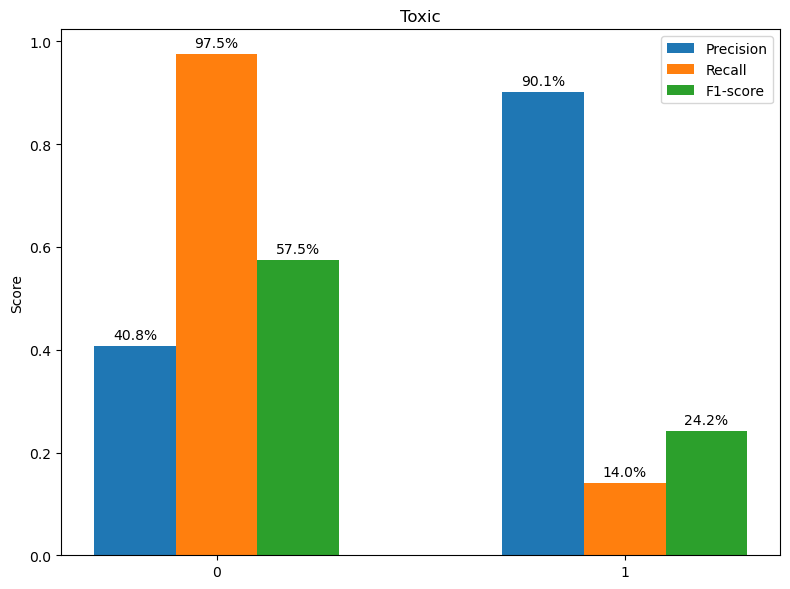

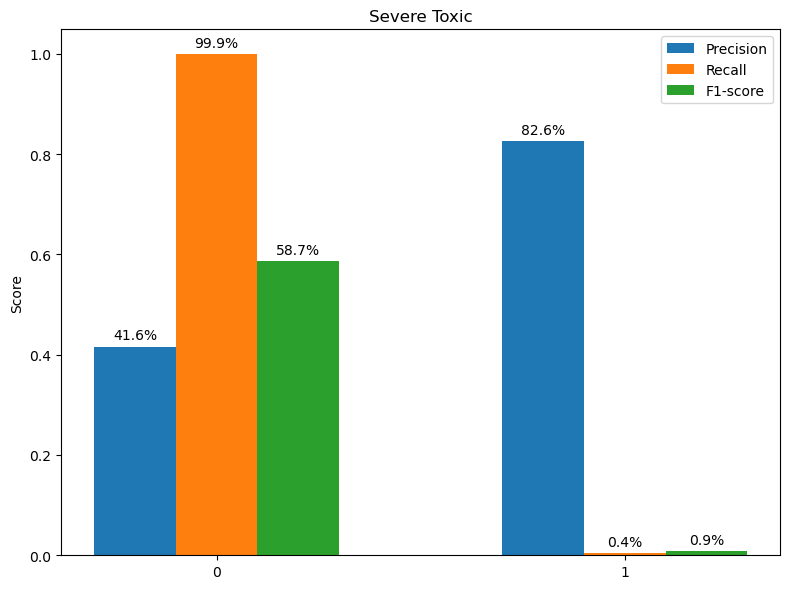

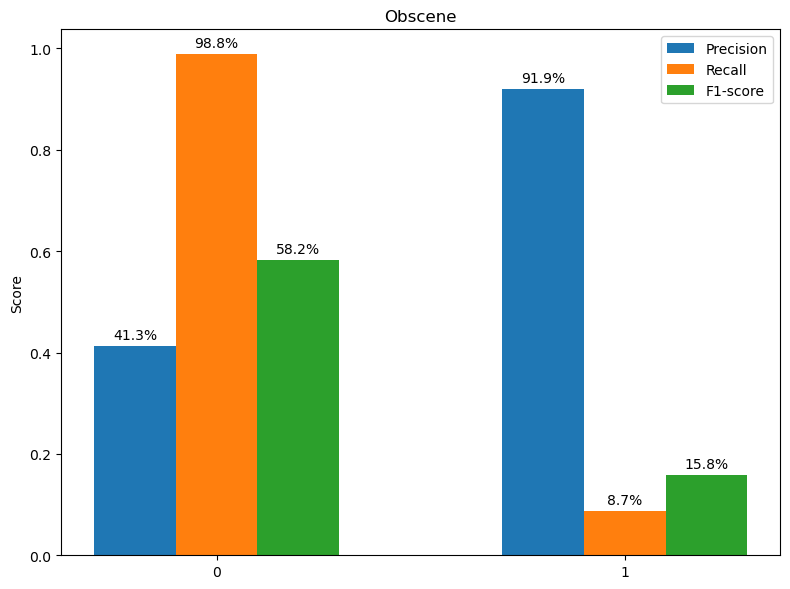

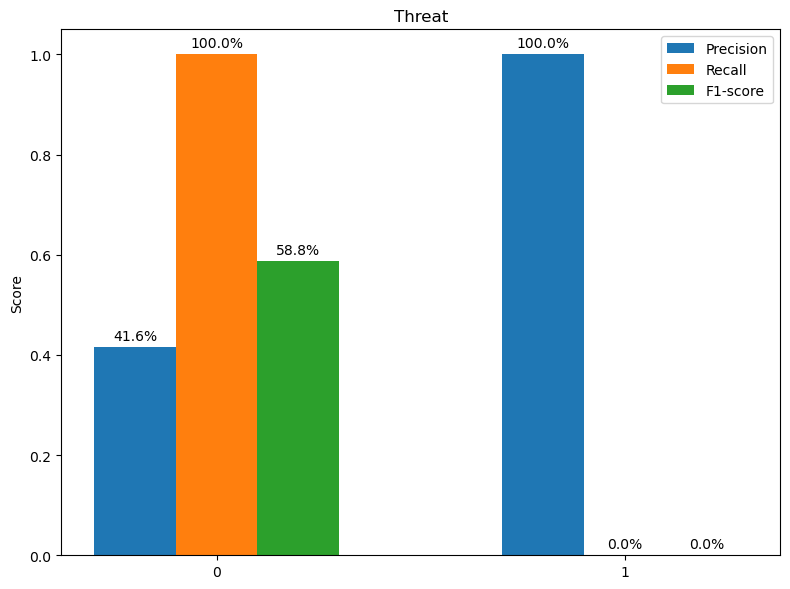

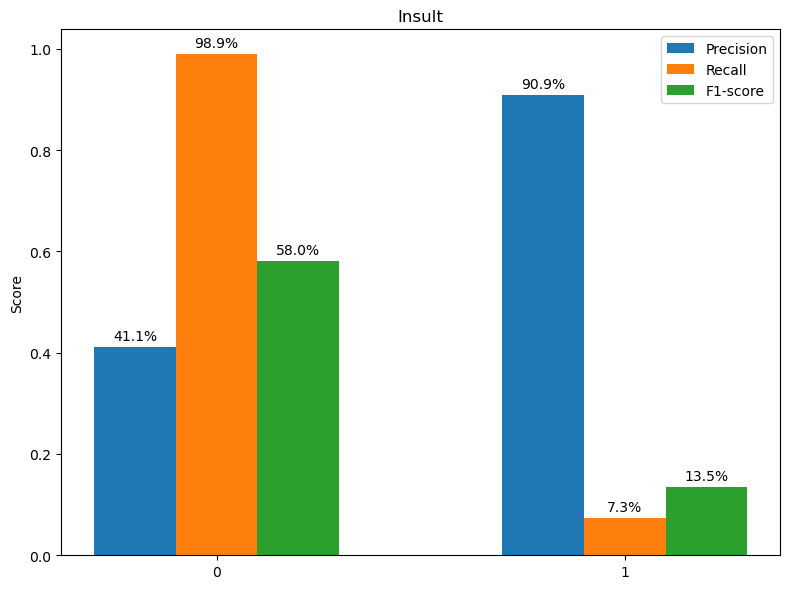

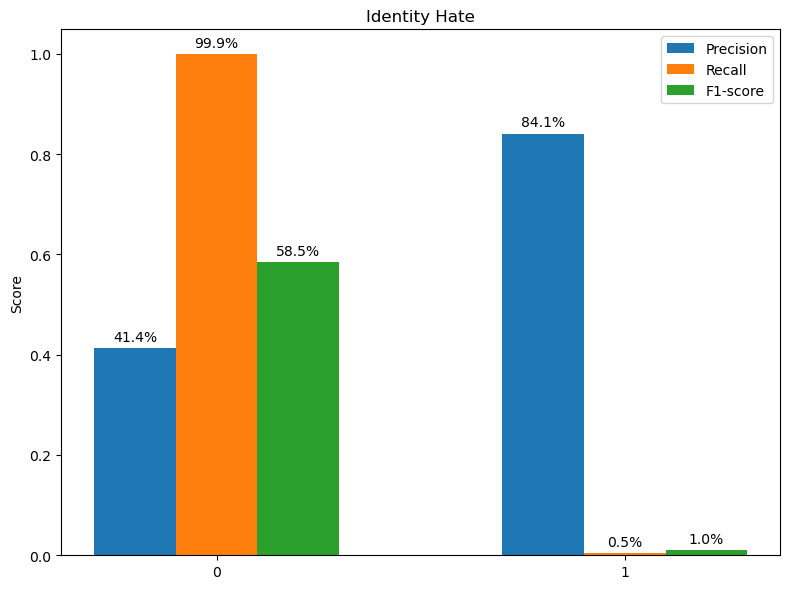

In [53]:
classes = ['0', '1']

plot_classification_report(label_data['toxic'],pred_mlp[0],classes,'Toxic')
plot_classification_report(label_data['severe_toxic'],pred_mlp[1],classes,'Severe Toxic')
plot_classification_report(label_data['obscene'],pred_mlp[2],classes,'Obscene')
plot_classification_report(label_data['threat'],pred_mlp[3],classes,'Threat')
plot_classification_report(label_data['insult'],pred_mlp[4],classes,'Insult')
plot_classification_report(label_data['identity_hate'],pred_mlp[5],classes,'Identity Hate')

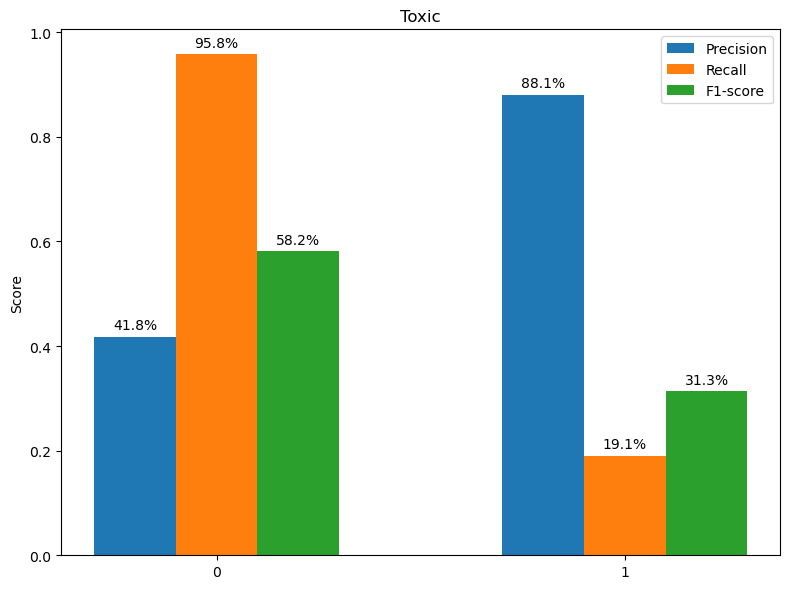

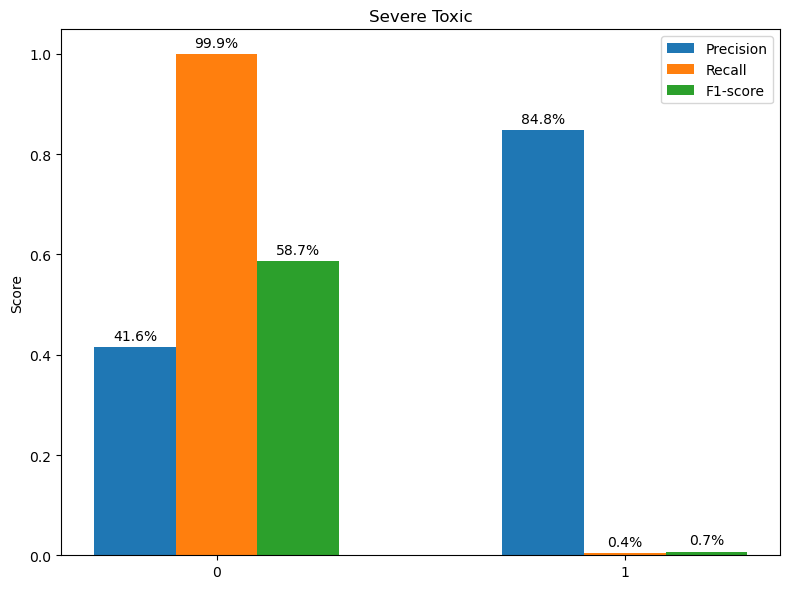

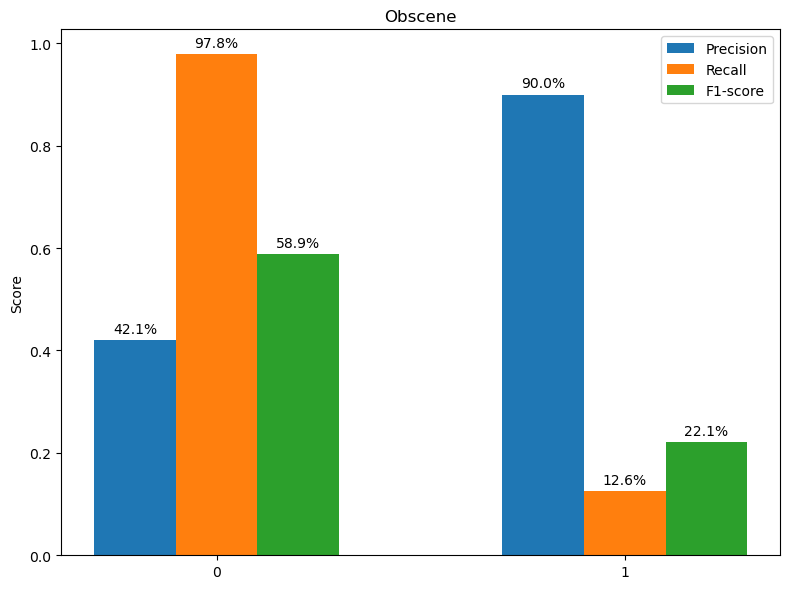

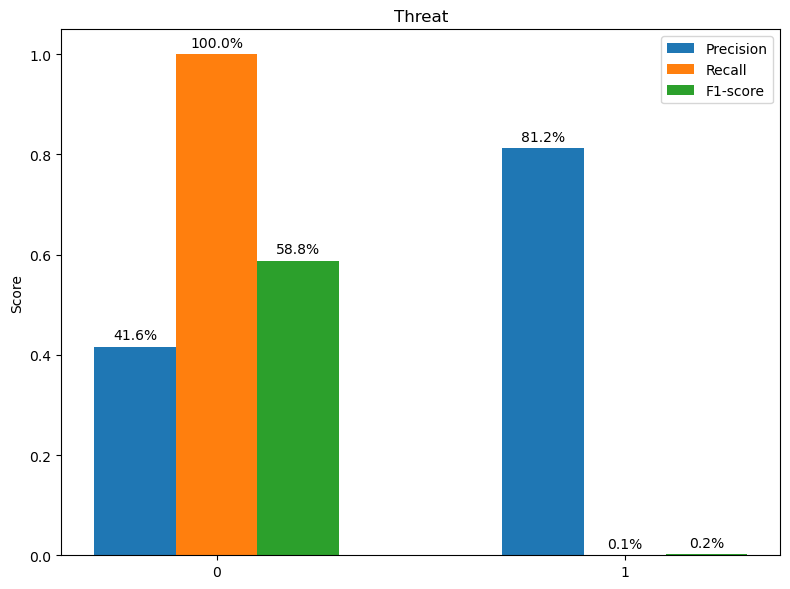

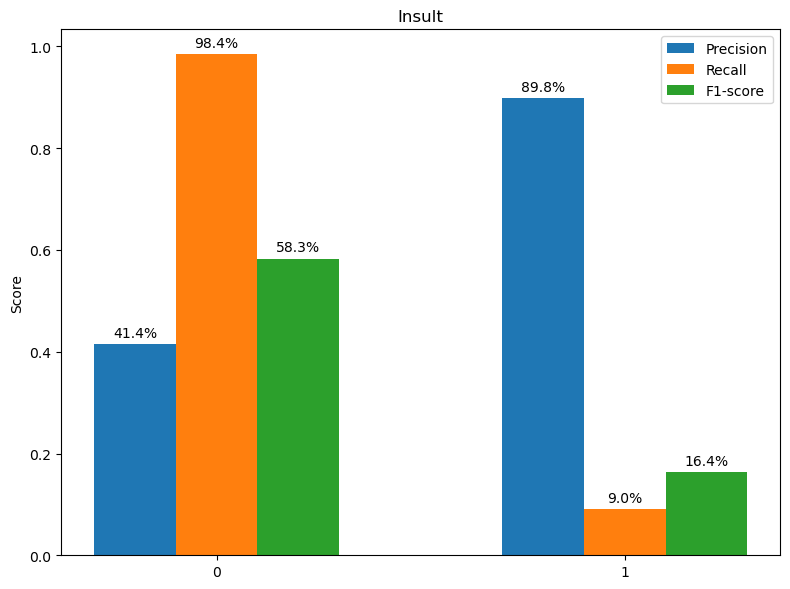

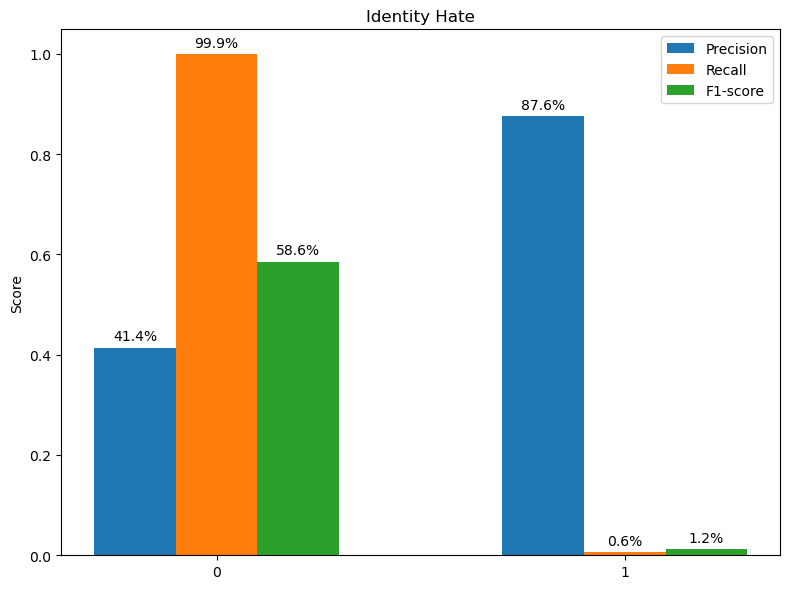

In [54]:

classes = ['0', '1']
plot_classification_report(label_data['toxic'],pred_cnn[0],classes,'Toxic')
plot_classification_report(label_data['severe_toxic'],pred_cnn[1],classes,'Severe Toxic')
plot_classification_report(label_data['obscene'],pred_cnn[2],classes,'Obscene')
plot_classification_report(label_data['threat'],pred_cnn[3],classes,'Threat')
plot_classification_report(label_data['insult'],pred_cnn[4],classes,'Insult')
plot_classification_report(label_data['identity_hate'],pred_cnn[5],classes,'Identity Hate')

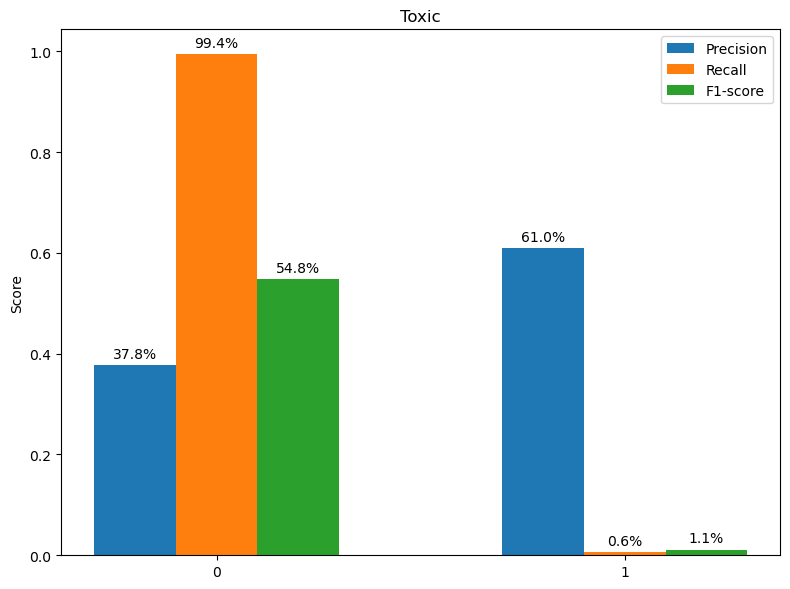

c:\Users\cavas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cavas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cavas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


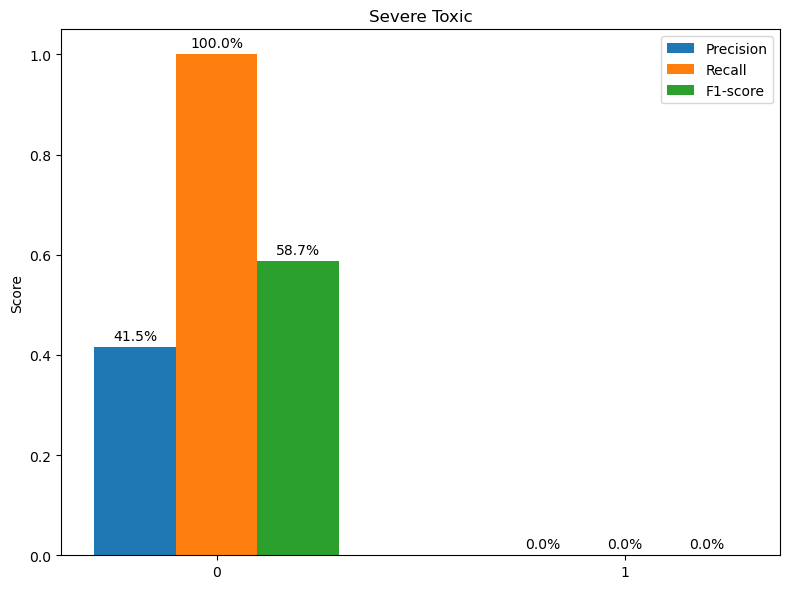

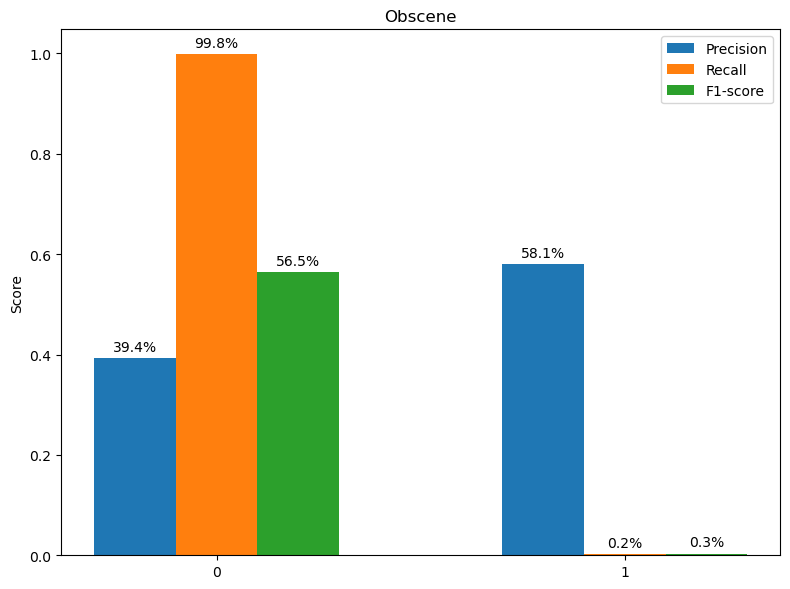

c:\Users\cavas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cavas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cavas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


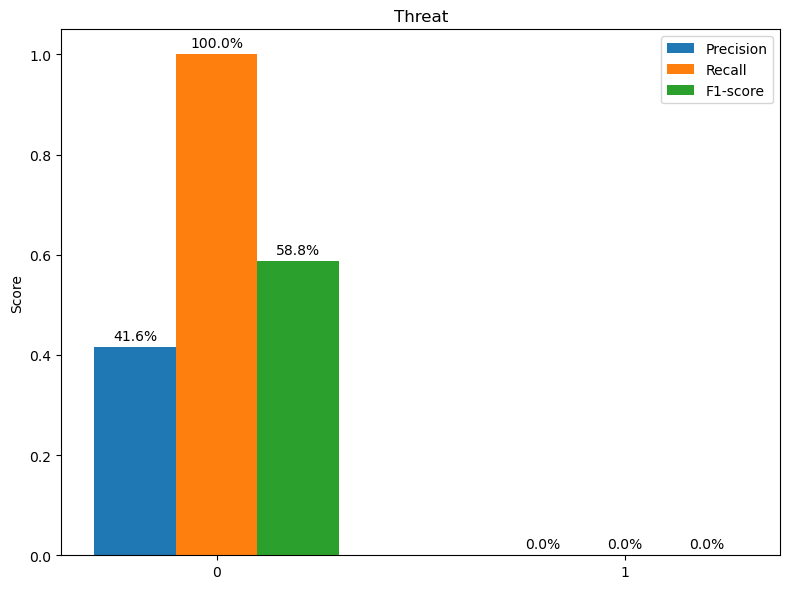

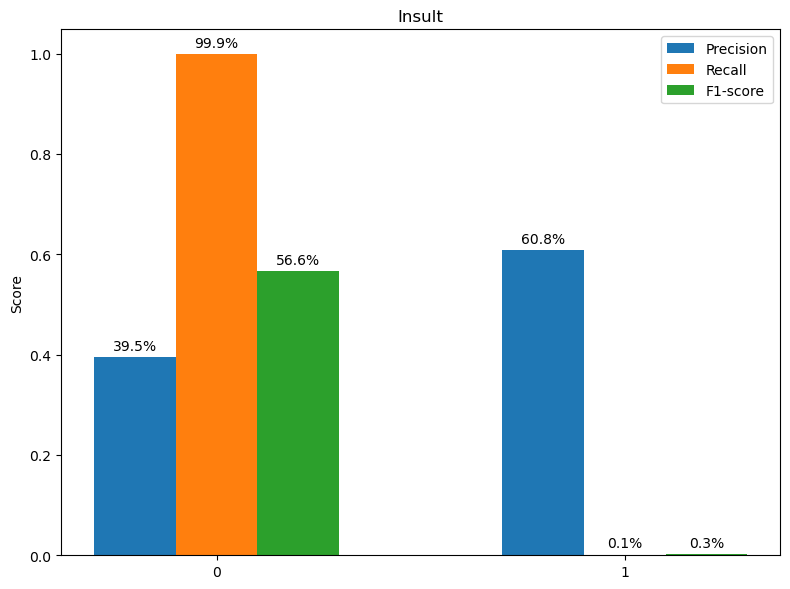

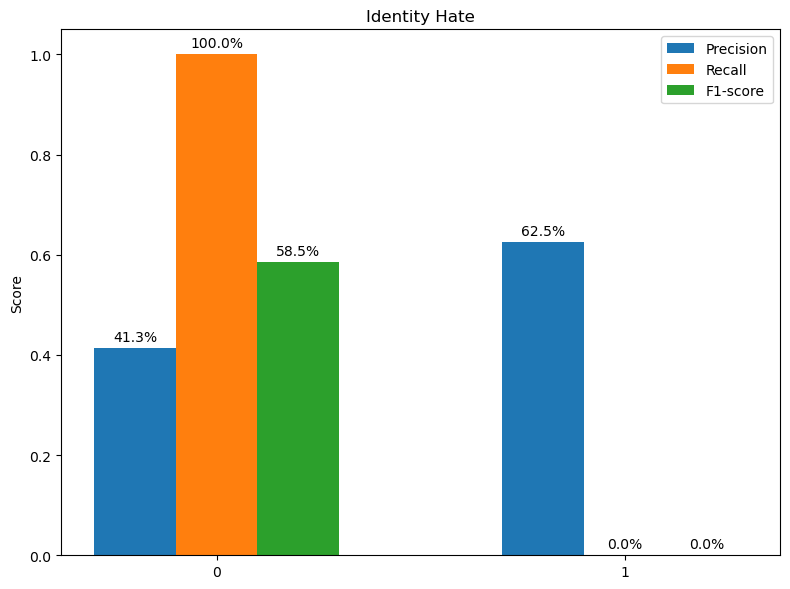

In [59]:
svm_label = label_data
svm_label = svm_label.drop('id',axis=1)

svm_y = pd.DataFrame(y_pred_svm,columns=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
svm_y = (svm_y >= 0.5).astype(int)  

classes = ['0', '1']
plot_classification_report(label_data['toxic'],svm_y['toxic'],classes,'Toxic')
plot_classification_report(label_data['severe_toxic'],svm_y['severe_toxic'],classes,'Severe Toxic')
plot_classification_report(label_data['obscene'],svm_y['obscene'],classes,'Obscene')
plot_classification_report(label_data['threat'],svm_y['threat'],classes,'Threat')
plot_classification_report(label_data['insult'],svm_y['insult'],classes,'Insult')
plot_classification_report(label_data['identity_hate'],svm_y['identity_hate'],classes,'Identity Hate')

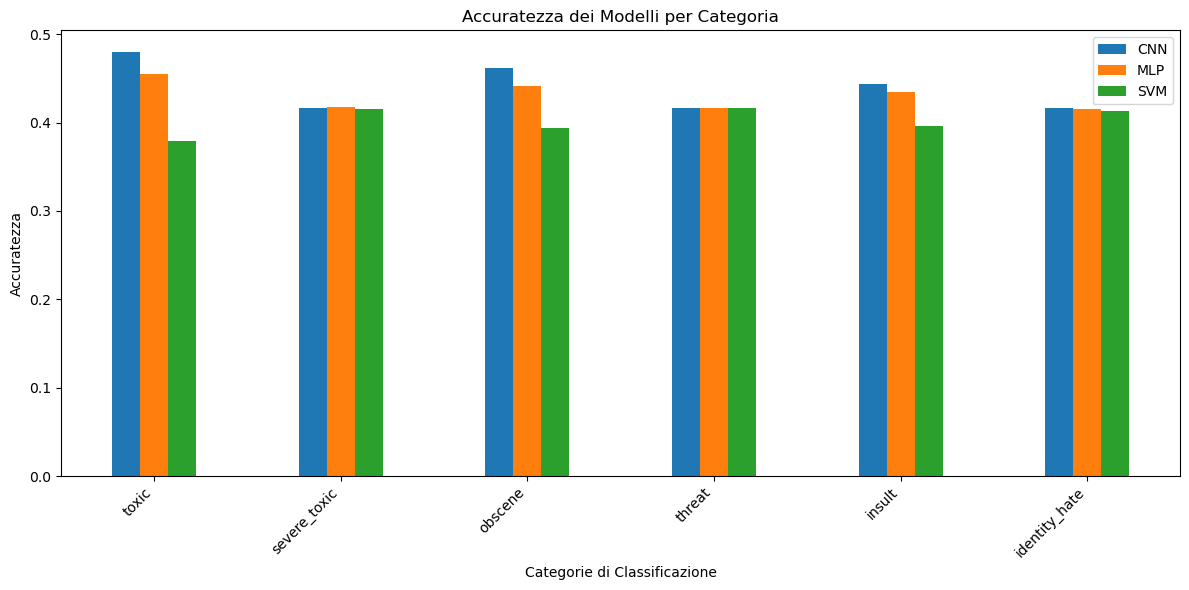

In [70]:

classes =["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

toxic_accuracy_cnn = accuracy_score(label_data['toxic'], pred_cnn[0])
severe_cnn = accuracy_score(label_data['severe_toxic'], pred_cnn[1])
obscene_cnn = accuracy_score(label_data['obscene'], pred_cnn[2])
threat_cnn = accuracy_score(label_data['threat'], pred_cnn[3])
insult_cnn = accuracy_score(label_data['insult'], pred_cnn[4])
identity_cnn = accuracy_score(label_data['identity_hate'], pred_cnn[5])
cnn_accuracy = [toxic_accuracy_cnn ,severe_cnn ,obscene_cnn ,threat_cnn ,insult_cnn,identity_cnn]

toxic_accuracy_mlp = accuracy_score(label_data['toxic'], pred_mlp[0])
severe_mlp = accuracy_score(label_data['severe_toxic'], pred_mlp[1])
obscene_mlp = accuracy_score(label_data['obscene'], pred_mlp[2])
threat_mlp = accuracy_score(label_data['threat'], pred_mlp[3])
insult_mlp = accuracy_score(label_data['insult'], pred_mlp[4])
identity_mlp = accuracy_score(label_data['identity_hate'], pred_mlp[5])
mlp_accuracy = [toxic_accuracy_mlp ,severe_mlp ,obscene_mlp ,threat_mlp ,insult_mlp,identity_mlp]

toxic_accuracy_svm = accuracy_score(label_data['toxic'], svm_y['toxic'])
severe_svm = accuracy_score(label_data['severe_toxic'], svm_y['severe_toxic'])
obscene_svm = accuracy_score(label_data['obscene'], svm_y['obscene'])
threat_svm = accuracy_score(label_data['threat'], svm_y['threat'])
insult_svm = accuracy_score(label_data['insult'], svm_y['insult'])
identity_svm = accuracy_score(label_data['identity_hate'], svm_y['identity_hate'])
svm_accuracy = [toxic_accuracy_svm ,severe_svm ,obscene_svm ,threat_svm ,insult_svm,identity_svm]

svm_accuracy
models = ['CNN', 'MLP','SVM']
plot_accuracies([cnn_accuracy,mlp_accuracy,svm_accuracy],classes,models)